In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

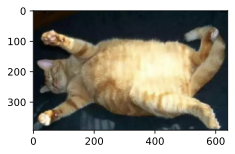

In [2]:
d2l.set_figsize()
img = d2l.Image.open('./data/cat.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

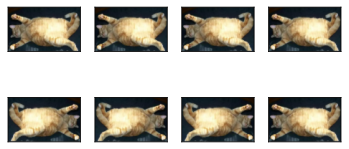

In [4]:
# 翻转和裁剪
apply(img, torchvision.transforms.RandomHorizontalFlip())

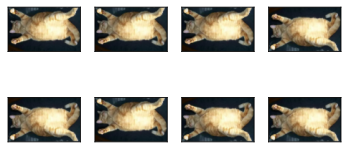

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

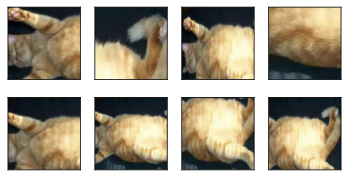

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200),
    scale=(0.1, 1),
    ratio=(0.5, 2)
)
apply(img, shape_aug)

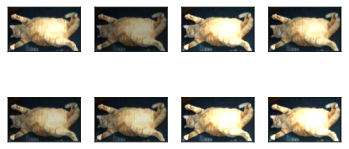

In [7]:
# 调整：亮度、对比度、饱和度和色调
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0))

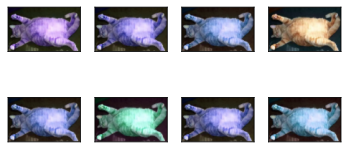

In [8]:
# 更改色调
apply(img, torchvision.transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5))

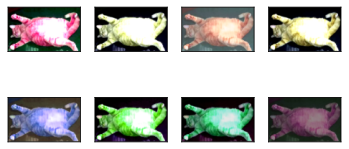

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

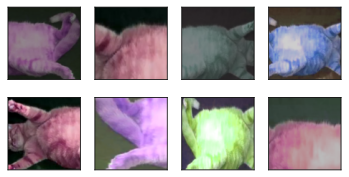

In [10]:
# 结合多种图像增广方法
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug]
)
apply(img, augs)

Files already downloaded and verified


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

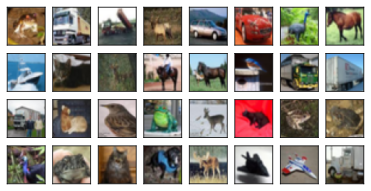

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="./data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [12]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="./data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [14]:
#@sve
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """ 用多GPU进行模型训练 """
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度; 储存训练损失、训练准确度、实例数、特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3], None)) 
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [15]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

D:\Anaconda\envs\wz_py_3_8\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.205, train acc 0.929, test acc 0.837
1746.8 examples/sec on [device(type='cuda', index=0)]


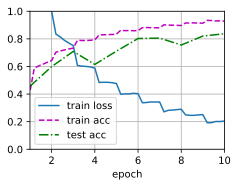

In [16]:
train_with_data_aug(train_augs, test_augs, net)

In [17]:
# 迁移学习: 将从源数据集学到的知识迁移到目标数据集
# 模型微调：利用已经训好的源模型中的知识

In [18]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [20]:
import os

train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

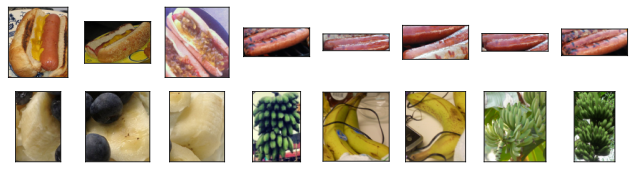

In [21]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [22]:
# 数据预处理
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize,
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])

In [23]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

D:\Anaconda\envs\wz_py_3_8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\wz_py_3_8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\18801/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [24]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [25]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_normal_(finetune_net.fc.weight)

D:\Anaconda\envs\wz_py_3_8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\wz_py_3_8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.1013,  0.0121,  0.0113,  ...,  0.0057,  0.0879,  0.0105],
        [ 0.0518,  0.0779,  0.0229,  ..., -0.0604, -0.0582, -0.0013]],
       requires_grad=True)

In [29]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, bathc_size=64, num_epochs=5, param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.211, train acc 0.935, test acc 0.920
23.5 examples/sec on [device(type='cuda', index=0)]


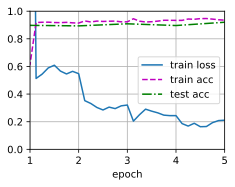

In [30]:
train_fine_tuning(finetune_net, 5e-5)

In [ ]:
# 冻结参数不进行训练， 示例
for param in finetune_net.parameters():
    param.requires_grad = False
finetune_net.fc.weight.requires_grad = True
finetune_net.fc.bias.requires_grad = True

In [ ]:
# 使用预训练的模型的热狗权重
weight = finetune_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]  # torch.Size([1, 512])
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
not_hotdog_w = torch.randn_like(hotdog_w)
finetune_net.fc.weight.data = torch.cat((hotdog_w, not_hotdog_w), dim=0)
finetune_net.fc.bias.data.fill_(0)

loss 0.350, train acc 0.845, test acc 0.841
23.8 examples/sec on [device(type='cuda', index=0)]


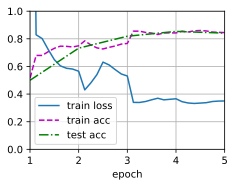

In [31]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

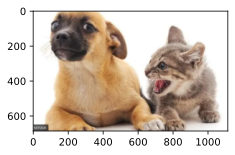

In [34]:
d2l.set_figsize()
img = d2l.plt.imread('./data/catdog.png')
d2l.plt.imshow(img);

In [35]:
#@save 
def box_corner_to_center(boxes):
    """ 从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """ 从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [36]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [37]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [38]:
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

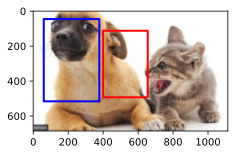

In [39]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的真实边界框

不同的模型使用的区域采样方法可能不同。 这里我们介绍其中的一种方法：以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。 这些边界框被称为锚框（anchor box）